<h1> Классификация комментариев на позитивные и негативные

<h2>1. Подготовка

<h3>1.1. Изучим данные из файла

<b>1.1.2. Импортируем необходимые нам алгоритмы и функции:

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
import torch
import transformers
import numpy as np
from tqdm import notebook
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

<b>1.1.3. Импортируем данные:

In [2]:
data = pd.read_csv('toxic_comments.csv')
pd.set_option('display.max_columns', None)

In [3]:
print('Посмотрим на первые 5 строк датафрейма data:')
display(data.head())
print('')
print('')
print('Посмотрим общую информацию о датафрейме применив метод .info()')
display(data.info())

Посмотрим на первые 5 строк датафрейма data:


,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0




Посмотрим общую информацию о датафрейме применив метод .info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


None

<b>1.1.4. Описание данных

Данные находятся в файле `toxic_comments.csv`.

    - Столбец *text* содержит текст комментария
    - Столбец *toxic* содержит целевой признак

<h3>1.2. Проверим данные на ошибки

В данных отсутствуют NAN-значения.

Проверим, присутствуют ли в данных задублированные записи.

In [4]:
data.duplicated().sum()

0

Задублированных записей нет.

<h3>1.3. Подготовим данные

В целях обучения модели классификации применим векторные представления на базе **BERT**.

Построить векторы текстов нам поможет предобученная на русских текстах модель **RuBERT**.

<b>1.3.1. Начинаем предобработку текстов:

<i>Следующий код представлен для ознакомления и закомментирован, поскольку был выполнен с помощью аппаратного ускорителя GPU в COLAB.

Инициализируем токенизатор как объект класса **BertTokenizer()**.

Передадим ему аргумент **vocab_file** — это файл со словарём, на котором обучалась модель.

<i>Получение эмбеддингов на локальном компьютере без ускорения GPU у нас заняло бы около 80 часов.

Поэтому обратимся к COLAB и подключим аппаратный ускоритель GPU.
    
Оставим закомментированный код, чтобы описать этапы получения эмбенддингов.

In [5]:
#tokenizer = transformers.BertTokenizer(vocab_file = 'vocab.txt')

Токенизируем каждую запись:

In [6]:
#tokenized = data['text'].apply(lambda x: tokenizer.encode(x, add_special_tokens = True, truncation=True, max_length=512)) 

Пусть стандартной длиной вектора n будет длина наибольшего во всём датасете вектора. Остальные векторы дополним нулями:

In [7]:
#max_len = 0
#for i in tokenized.values:
#    if len(i) > max_len:
#        max_len = len(i)
#
#padded = np.array([i + [0] * (max_len - len(i)) for i in tokenized.values])

Теперь поясним модели, что нули не несут значимой информации.

Отбросим эти токены и «создадим маску» для действительно важных токенов, то есть укажем нулевые и не нулевые значения:

In [8]:
#attention_mask = np.where(padded != 0, 1, 0)

Инициализируем конфигурацию **BertConfig**.

В качестве аргумента передадим ей **JSON-файл** с описанием настроек модели.

In [9]:
#config = transformers.BertConfig.from_json_file('bert_config.json')

Инициализируем саму модель класса **BertModel**.

Передадим ей файл с предобученной моделью:

In [10]:
#model = transformers.BertModel.from_pretrained('pytorch_model.bin', config = config) 

<i>Подключение GPU:</i>

In [11]:
#model = model.cuda() 

Эмбеддинги модель BERT создаёт **батчами**. Чтобы хватило оперативной памяти, сделаем размер батча небольшим:

In [12]:
#batch_size = 100

Сделаем цикл по батчам. Отображать прогресс будет функция **notebook()**.

Преобразуем данные в формат **тензоров** — многомерных векторов в библиотеке torch.

Тип данных **LongTensor** хранит числа в «длинном формате», то есть выделяет на каждое число 64 бита.

Чтобы получить эмбеддинги для батча, передадим модели данные и маску.

Для ускорения вычисления функцией **no_grad()** в библиотеке torch укажем, что градиенты не нужны: модель BERT обучать не будем.

Из полученного тензора извлечём нужные элементы и добавим в список всех эмбеддингов.

In [13]:
#embeddings = []
#
#for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
#    batch = torch.LongTensor(padded[batch_size * i:batch_size * (i + 1)]).cuda() 
#    attention_mask_batch = torch.LongTensor(attention_mask[batch_size * i:batch_size * (i + 1)]).cuda() 
#    
#    with torch.no_grad():
#        batch_embeddings = model(batch, attention_mask = attention_mask_batch)

<i>Возвращение к CPU:   

In [14]:
#    embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())

Вот так проходил процесс создание эмбеддингов:

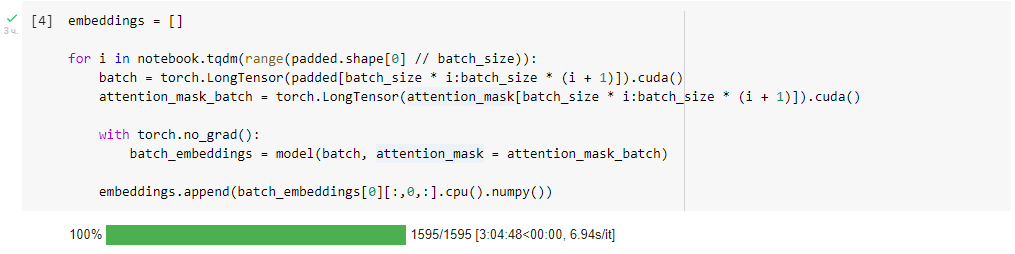

Соберём все эмбеддинги в матрицу признаков вызовов функции **concatenate()**:

In [15]:
#features = np.concatenate(embeddings)

Мы уже подготовили файл с признаками и сейчас просто выгрузим его.

Подготовка файла происходила следующим образом в COLAB:

In [16]:
#data_features = []
#data_features['features'] = features
#data_features.to_csv('features', index = False)

In [17]:
data_features = pd.read_csv('features')

Сформируем новый датафрейм.

Как мы помним, всего у нас было 159571 запись. После получения эмбеддингов, мы сформировали датафрейм из 159500 признаков.

При попытке сформировать для оставшихся 71 записи отдельно эмбеддинги - мы получили ошибку недостатка памяти. Удалим эти 71 запись, это 0,04% данных.

In [18]:
new_data = data_features
target = data['toxic']
target.drop(target.tail(71).index,inplace = True)
new_data['target'] = data['toxic']

<h2>2. Обучение

<h3>2.1. Сформируем тренировочную и валидационную выборки

In [19]:
features = new_data.drop(['target'], axis=1)
target = new_data['target']

In [20]:
display(features)
display(features.info())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
0,-0.090838,-0.075571,-0.155815,0.054798,0.315262,0.364224,0.118672,-0.153587,0.076749,-0.009836,0.133690,0.093436,0.035081,-0.049546,-0.589147,0.056555,-0.082245,0.387883,0.233338,0.357530,-0.251688,-0.090108,-0.121918,-0.145788,0.045280,-0.327239,-0.063473,0.143882,0.344876,-0.220382,0.425635,0.418775,0.098438,0.177753,0.058327,0.016758,-1.506655,-0.034746,0.032214,-0.281587,-0.024466,0.235556,0.055831,0.098396,0.033742,0.960248,0.520964,0.060045,0.516870,-0.292755,-0.116197,-0.356076,0.415774,-1.177626,0.128331,0.123791,0.120106,-0.220371,-0.172421,0.350059,0.219732,0.070035,0.101263,-0.131086,-0.082374,-0.074677,0.109473,0.150639,-0.039194,0.102611,0.012086,0.102365,-0.143506,-0.023587,-0.217733,0.318955,-0.013033,0.124689,0.002271,0.008864,0.027230,-0.288125,-0.232371,0.149046,0.063937,-0.265149,-0.376262,0.010839,-0.414316,-0.074015,-0.214932,-0.122076,-0.033309,-0.272085,-0.228703,-0.537001,-0.046653,-0.134457,0.060357,-0.073585,0.091210,1.320457,0.579132,-0.297777,-2.250899,0.079864,-0.455618,-0.429774,0.200889,-0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153132 entries, 0 to 153131
Columns: 768 entries, 0 to 767
dtypes: float64(768)
memory usage: 897.3 MB


None

In [22]:
features = features.astype('float32')
features = np.nan_to_num(features)

Разделим признаки и target на обучающую и тестовую (валидационую выборки) в соотношении 75/25.

In [23]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size = 0.25, random_state = 12345)

Посмотрим на размеры полученных выборок

In [24]:
print('Размер тренировоной выборки:')
display('Признаки.Тренировочная выборка:', features_train.shape)
display('Целевой признак.Тренировочная выборка:', target_train.shape)
print('')
print('Размер валидационной выборки:')
display('Признаки.Валидационная выборка:', features_valid.shape)
display('Целевой признак.Валидационная выборка:', target_valid.shape)

Размер тренировоной выборки:


'Признаки.Тренировочная выборка:'

(114849, 768)

'Целевой признак.Тренировочная выборка:'

(114849,)


Размер валидационной выборки:


'Признаки.Валидационная выборка:'

(38283, 768)

'Целевой признак.Валидационная выборка:'

(38283,)

Оценим баланс между значениями в столбце, отвечающем за целевой признак.

In [25]:
target.value_counts()

0    137556
1     15576
Name: target, dtype: int64

В наших данных <b>присутствует дисбаланс</b>. Это необходимо скорректировать.

<h3>2.2. Обучим модели

Помимо рассчета F1-меры, сохраним необходимое для обучения модели время.

<b>2.2.1. Дерево решений

In [26]:
start_time = time.time()

model_DTC = DecisionTreeClassifier(random_state = 12345, class_weight = 'balanced')
model_DTC = model_DTC.fit(features_train, target_train)
model_DTC_predictions = model_DTC.predict(features_valid)

end_time = time.time()
time_model = round((end_time - start_time), 2)

f1 = f1_score(target_valid, model_DTC_predictions)
print("F1-мера для Дерева решений на валидационной выборке:", f1)
print("Общее время обучения модели", time_model, 'секунд')

F1-мера для Дерева решений на валидационной выборке: 0.36713602893682995
Общее время обучения модели 747.65 секунд


Запишем значение F1-Меры для Дерева решений.

In [27]:
DecisionTreeClassifier_data = pd.DataFrame({'model': ['DecisionTreeClassifier'], 'F1': [f1], 'time': [time_model]})
display (DecisionTreeClassifier_data)

,model,F1,time
0,DecisionTreeClassifier,0.367136,747.65


<b>2.2.2. Случайный лес

In [28]:
best_model = None
best_result = 0
best_est = None

for est in range(1, 11):
    model_RFC = RandomForestClassifier(random_state = 12345, n_estimators = est, class_weight='balanced')
    model_RFC = model_RFC.fit(features_train, target_train)
    model_RFC_predictions = model_RFC.predict(features_valid)
    result = f1_score(target_valid, model_RFC_predictions)
    if result > best_result:
        best_model = model_RFC
        best_result = result
        best_est = est

In [29]:
start_time = time.time()

model_RFC = RandomForestClassifier(random_state = 12345, n_estimators = best_est, class_weight='balanced')
model_RFC = model_RFC.fit(features_train, target_train)
model_RFC_predictions = model_RFC.predict(features_valid)

end_time = time.time()
time_model =  round((end_time - start_time), 2)

f1 = f1_score(target_valid, model_RFC_predictions)
print("F1-мера для Случайного леса на валидационной выборке:", f1)
print("Наилучшее количество деревьев", best_est)
print("Общее время обучения модели", time_model, 'секунд')

F1-мера для Случайного леса на валидационной выборке: 0.38129226145755074
Наилучшее количество деревьев 7
Общее время обучения модели 91.77 секунд


In [30]:
RandomForestClassifier_data = pd.DataFrame({'model': ['RandomForestClassifier'], 'F1': [f1], 'time': [time_model]})
display (RandomForestClassifier_data)

,model,F1,time
0,RandomForestClassifier,0.381292,91.77


<b>2.2.3. Логистическая регрессия

Для логистической регрессии много данных.

Возьмем случайную выборку.

In [31]:
new_data_2 = new_data.sample(5000).reset_index(drop = True)

features_2 = new_data_2.drop(['target'], axis=1)
target_2 = new_data_2['target']

features_2 = features_2.astype('float16')

features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(
    features_2, target_2, test_size = 0.5, random_state = 12345)

In [32]:
start_time = time.time()

model_LR = LogisticRegression(random_state = 12345, solver = 'liblinear', class_weight='balanced')
model_LR = model_LR.fit(features_train_2, target_train_2)
model_LR_predictions = model_LR.predict(features_valid_2)

end_time = time.time()
time_model =  round((end_time - start_time), 2)

f1 = f1_score(target_valid_2, model_LR_predictions)
print("F1-мера для Логистичекой регрессии на валидационной выборке:", f1)
print("Общее время обучения модели", time_model, 'секунд')

F1-мера для Логистичекой регрессии на валидационной выборке: 0.5593220338983051
Общее время обучения модели 2.33 секунд


In [33]:
LogisticRegression_data = pd.DataFrame({'model': ['LogisticRegression'], 'F1': [f1], 'time': [time_model]})
display (LogisticRegression_data)

,model,F1,time
0,LogisticRegression,0.559322,2.33


<b>2.2.4. Градиентный бустинг

In [34]:
start_time = time.time()

model_CBC = CatBoostClassifier(loss_function = "Logloss", iterations = 3, depth = 10)
model_CBC = model_CBC.fit(features_train, target_train, verbose=10)
model_CBC_predictions = model_CBC.predict(features_valid)

end_time = time.time()
time_model = round((end_time - start_time), 2)

f1 = f1_score(target_valid, model_CBC_predictions)
print("F1-мера для Градиентного бустинга на валидационной выборке:", f1)
print("Общее время обучения модели", time_model, 'секунд')

Learning rate set to 0.5
0:	learn: 0.3242438	total: 10.8s	remaining: 21.7s
2:	learn: 0.2257943	total: 33.8s	remaining: 0us
F1-мера для Градиентного бустинга на валидационной выборке: 0.3893273205561819
Общее время обучения модели 54.41 секунд


In [35]:
CatBoostClassifier_data = pd.DataFrame({'model': ['CatBoostClassifier'], 'F1': [f1], 'time': [time_model]})
display (CatBoostClassifier_data)

,model,F1,time
0,CatBoostClassifier,0.389327,54.41


<h3>2.3. F1-мера

Чем выше значение F1-меры, тем лучше.

Объединим датафреймы с данными о значениях F1-меры на тренировочных выборках.

In [36]:
pd.concat([DecisionTreeClassifier_data, RandomForestClassifier_data, LogisticRegression_data, CatBoostClassifier_data], ignore_index = True)

,model,F1,time
0,DecisionTreeClassifier,0.367136,747.65
1,RandomForestClassifier,0.381292,91.77
2,LogisticRegression,0.559322,2.33
3,CatBoostClassifier,0.389327,54.41


Применим метод поиска наилучших гиперпараметров для модели Логистическая регрессия.

In [37]:
lr = LogisticRegression()

solver_options = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
max_iter_options = [2, 10, 20, 25, 30]
multi_class_options = ['auto', 'ovr', 'multinomial']
penalty_options = ['l1', 'l2', 'elasticnet', 'none']

param_grid = dict(
    solver = solver_options,
    max_iter = max_iter_options,
    multi_class = multi_class_options,
    penalty = penalty_options)

grid = GridSearchCV(lr, param_grid, cv = 5, scoring = 'f1')

grid.fit(features_train_2, target_train_2)

start_time = time.time()

model_LR_2 = LogisticRegression(random_state = 12345, **grid.best_params_)
model_LR_2 = model_LR_2.fit(features_train_2, target_train_2)
model_LR_2_predictions = model_LR_2.predict(features_valid_2)

end_time = time.time()
time_model =  round((end_time - start_time), 2)

f1 = f1_score(target_valid_2, model_LR_predictions)
print("F1-мера для Логистичекой регрессии на валидационной выборке:", f1)
print("Общее время обучения модели", time_model, 'секунд')

F1-мера для Логистичекой регрессии на валидационной выборке: 0.5593220338983051
Общее время обучения модели 0.56 секунд


<h2>Выводы

В данном проекте мы познакомились с возможностью подключения аппаратного ускорителя от COLAB, а также создали эмбеддинги с помощью BERT.

Создание эмбеддингов проходило на стороннем ресурсе. В проекте мы отразили код, а также загрузили результаты получения эмбеддингов.

После мы сформировали новый датафрейм с признаками, в том числе с целевым признаком.

Датафрейм содержал 159 700 записей.

Был обнаружен дисбаланс классов, который мы учли при обучении моделей.

Мы обучили 4 модели машинного обучения:

    Дерево решений
	Случайный лес
	Логистическая регрессия
	Градиентный бустинг

Логистическая регрессия не смогла справиться со всем набором данных, поэтому нам пришлось взять случайный набор элементов в количестве 3000 элементов.

Наибольшое значение F1-меры удалось достичь моделе Логистической регрессии.

Также, эта модель показало наименьшее необходимое количество времени. Но это не объективный признак. Для Логистической регрессии нам пришлось урезать набор данных.